<a href="https://colab.research.google.com/github/vossrf/EISFGN/blob/main/EISFGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Efficient Incremental Simulation of *1/f* Noises

The following cells provide working Python examples of the code presented in the article **Efficient Incremental Simulation of *1/f* Noises** submitted to the World Scientific Journal **[Fractals](https://www.worldscientific.com/worldscinet/fractals)** in December 2020 and revised August 2021.

The code presented below uses both Python's **numpy** and **numba** to speed execution. Most of the simulations results in the article used optimized C-code to further speed execution for long runs. Matplotlib is used here for some simple plots. Figures in the article were generated with the author's ancient VossPlot package 
(see [Amazon](https://www.amazon.com/VossPlot-Scientific-Technical-University-California/dp/0387142150) or
[PBworks](http://vossplot.pbworks.com/w/page/51975702/VossPlot)).

Richard F. Voss
rvoss@fau.edu

Copyright 2021 Richard F. Voss

License: Creative Commons Attribution 4.0 International

Click the solid $\rhd$ triangle symbols to open the hidden cells in each section.

### The following cell imports the necessary modules.

In [2]:
import sys, time
import numpy as np
import numba
import matplotlib.pyplot as plt

print(sys.version)

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


### SQU sources
**`SQUinit()`** initializes the parameters for the array of sources while **`GenSQU(X)`** generates in-place samples in array **`X`**.

The following uses **`random()-0.5`** for uniformly distributed random values from -0.5 to 0.5. This could be replaced by **`standard_normal()`** for a normal/Gaussian distribution.

In [3]:
from numpy.random import random as RanVal
# from numpy.random import standard_normal as RanVal  # uncomment for Gaussian and remove '-0.5'

def SQUinit(Ns,tau0,taumin=1):
  "return the Sv, St and Sk numpy arrays for Ns sources with period ratio tau0 and initial Source sum Ssum"
  Sv = np.zeros(Ns,dtype=np.float64)   # source random values, initially 0
  Sp = tau0*np.ones(Ns,dtype=np.int32) # source periods  
  Sp[0] = taumin                       # initial period different
  Sk = np.zeros(Ns,dtype=np.int32)     # source indices, 0 forces update
  Ssum = 0.0 
  return Ssum,Sk,Sp,Sv      

@numba.jit(nopython=True)      # pre compiles for faster execution
def GenSQU(X,Ssum,Sk,Sp,Sv):
  "fill np array X with SQU samples derived from Ssum,Sk,Sv SQU sources"
  for i in range(X.size):
    for k in range(Sk.size): # check sources for updates
      Sk[k] -= 1             # decrement current count
      if Sk[k]>0: break      # no change for this or higher k
      Ssum -= Sv[k]          # remove previous value from Ssum
      Sv[k] = RanVal()-0.5   # new random value (may use Gaussian here)
      Ssum += Sv[k]          # replace with new value      
      Sk[k] = Sp[k]          # reset count
    X[i] = Ssum              # save value  
  return Ssum                # return Ssum for continuity with next sample

### Generate and plot a SQU sample

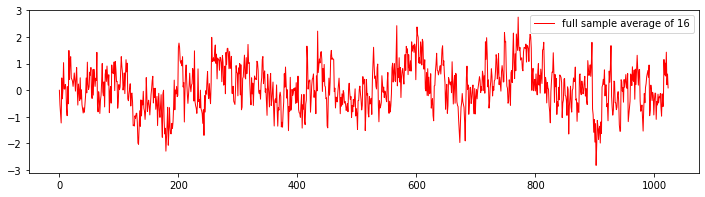

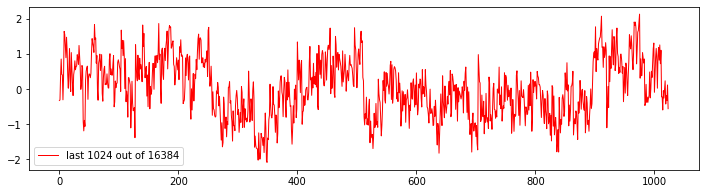

In [4]:
Ns = 12     # number of sources
tau0 = 2    # geometric sequence of tau's with ratio = tau0
N = 2**14   # sample size

Ssum,Sk,Sp,Sv = SQUinit(Ns,tau0) # initialize sources
X = np.empty(N,dtype=np.float32) # use 32-bit floats to save on memory
Ssum = GenSQU(X,Ssum,Sk,Sp,Sv)   # generate sample
f1 = plt.figure(1) 
navg=N//1024                     # generate averaged view
plt.plot(X.reshape((1024,navg)).mean(axis=1), color='red', linewidth=1, label='full sample average of %d'%navg)
plt.legend()
f1.set_size_inches(12,3)

f2 = plt.figure(2)               # show last 1024 samples
plt.plot(X[-1024:], color='red', linewidth=1, label='last 1024 out of %d'%N)
plt.legend()
f2.set_size_inches(12,3)  

### Scipy based functions for in-place FFT's and accumulation, log based averaging and display of spectral densities.

These work with either float32 or float64 numpy arrays.

In [5]:
from scipy.fftpack import rfft,irfft

@numba.jit(nopython=True)    # pre compile for faster execution  
def absFFT(data,SD):
  "add abs**2 of frequency components to SD"
  SD[0] += data[0]           # save average component
  n2 = len(data)//2
  for k in range(1,n2):
    k2 = 2*k
    s = data[k2]             # sin component
    c = data[k2-1]           # cos component
    SD[k] += c*c + s*s       # add amplitude
  SD[n2] += data[k2+1]**2    # highest frequency
  SD[n2+1] += 1              # count of averages

def addSD(data,SD):
  "in-place FFT of data, then add to spectral density"
  # SD has n//2 + 2 points, SD[0]=sum average, SD[-1]=count
  n = len(data)
  if len(SD)<n//2+2:
    print("SD array too small, need n//2+2 elements")
    exit()
  rfft(data,overwrite_x=True)  # in-place forward transform
  absFFT(data,SD)
    
def loglogSD(sd,nppd=5):
  "return log bin averaged fa,sda,avg,var,SDvar of spectral density, nppd points/decade"
  ns = 2*(len(sd)-2)                   # length of original sample
  scale = 2/(ns*ns*sd[-1])             # scale factor for sum(SD) = variance
  f = np.arange(1,len(sd)-1)
  bf = (nppd*np.log10(f)).astype(int)  # bin numbers for each freq
  Nb  = np.bincount(bf)                # bf based bin counts
  Sfa = np.bincount(bf,weights=f)      # bf based freq sums
  Ssd = np.bincount(bf,weights=sd[1:-1]) # bf based sd sums sd[0] = average
  bnz = Nb>0                           # non-zero bins
  Nb = Nb[bnz]                         # keep non-zero results   
  fa  = Sfa[bnz]/(ns*Nb)               # bin freq averages
  sda = scale*Ssd[bnz]/Nb              # bin SD averages
  return fa,sda,Nb,sd[0]/(ns*sd[-1]),np.sum(sd[1:-2])*scale   
    
def loglogFit(x,y,xmin=1,xmax=0):
  "return slope,A for y=Ax**slope for xmin <= x <= xmax or all if xmin>-xmax"
  if xmin>=xmax:    # simple linear fit of all data
    z,cov = np.polyfit(np.log(x),np.log(y),1,cov=True)
    xmin = np.min(x); xmax = np.max(x)
  else:
    keep = (x>=xmin)*(x<=xmax)   # select elements to fit   
    z,cov = np.polyfit(np.log(x[keep]),np.log(y[keep]),1,cov=True)
  err = np.sqrt(np.diag(cov))      # standard errors of coefficients  
  xfit = np.array((xmin,xmax))  
  yfit = np.exp(z[1])*xfit**z[0]
  return z,err,xfit,yfit  

def loglogPlot(x,y,xmin=0,xmax=0,popt='ro',fopt='b-',fignum=1):
  "generate loglog plot, if xmax>xmin: optional fit over x range"
  f = plt.figure(fignum)
  ax = plt.gca()
  exec("plt.loglog(x,y,%s)" % popt)
  if xmax>xmin:
    z,err,xfit,yfit = loglogFit(x,y,xmin,xmax)
    #print(z,err,xfit,yfit) 
    lab='slope %0.3f ± %0.3f'%(z[0],err[0])
    exec("plt.plot(xfit,yfit,%s,label=lab)" % fopt)
    plt.legend()    
  ax.grid()
  ax.set_aspect('equal', 'box')
  ax.set_xlabel('f')
  ax.set_ylabel('SD(f)')
  f.set_size_inches(8,8)

### Generate 100 SQU samples, collect and display their spectral density

100 samples of size 65536 in 0.85 sec
sample avg 4.255e-03 var 0.9957


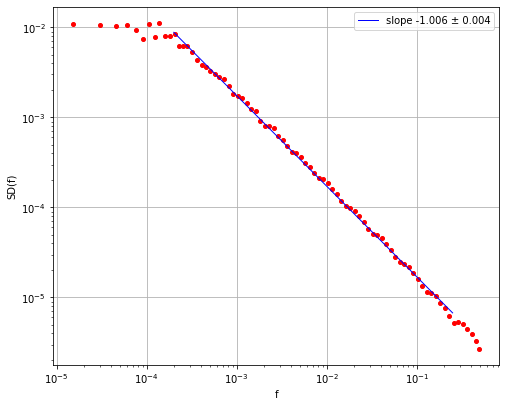

Text(0, 0.5, 'fxSD(f)')

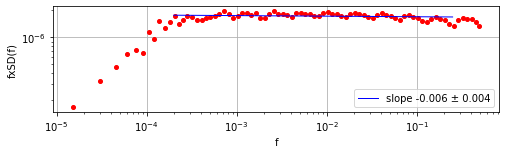

In [6]:
Ns = 12     # number of sources
tau0 = 2    # geometric sequence of tau's with ratio = tau0
N = 2**16   # sample size
Nrun = 100  # samples to average

Ssum,Sk,Sp,Sv = SQUinit(Ns,tau0)    # initialize sources
X = np.empty(N,dtype=np.float32)    # use 32-bit floats to save on memory
nsd = N//2+2                        # spectral density size 
sd = np.zeros(nsd,dtype=np.float32) # space for spectral density 

t0 = time.perf_counter()            # starting time
for m in range(Nrun):
  Ssum = GenSQU(X,Ssum,Sk,Sp,Sv)    # generate sample
  addSD(X,sd)                       # add to spectral density, this destroys X
print("%d samples of size %d in %0.2f sec" % (Nrun,N,time.perf_counter()-t0))  
fa,sda,na,avg,var = loglogSD(sd,20) # sd averaged to 20 points/decade
print("sample avg %0.3e var %0.4f" % (avg,var))
loglogPlot(fa,sda,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.show()
loglogPlot(fa,sda*fa,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.gca().set_ylabel('fxSD(f)')

### TRI sources
**`TRIinit()`** initializes the parameters for the array of sources while **`GenTRI(X)`** generates in-place samples in array **`X`**.

The following uses **`random()-0.5`** for uniformly distributed random values from -0.5 to 0.5. This could be replaced by **`standard_normal()`** for a normal/Gaussian distribution.

In [7]:
from numpy.random import random as RanVal
# from numpy.random import standard_normal as RanVal  # uncomment for Gaussian and remove '-0.5'

def TRIinit(Ns,tau0,taumin=1):
  "return the Sv,Sk,Sp,Sc numpy arrays for Ns sources with period tau0"
  Sv = np.zeros(Ns,dtype=np.float64)    # source values
  Sk = np.zeros(Ns,dtype=np.int32)      # source indices, 0 forces update
  Sp = np.empty(Ns,dtype=np.int32)      # source periods
  Sc = np.zeros(Ns,dtype=np.float64)    # value change between periods
  for k in range(Ns):                   # initialize sources
    Sv[k] = RanVal()-0.5                # initial random value (could use Gaussian)
    Sp[k]= taumin*tau0**k               # source period
  return Sk,Sp,Sv,Sc

@numba.jit(nopython=True)     # pre compile for faster execution
def GenTRI(X,Sk,Sp,Sv,Sc):
  "fill np array X with TRI samples derived from Sk,Sp,Sv,Sinc TRI sources"
  for i in range(X.size):
    X[i] = 0.0                # initialize current source Ssum
    for k in range(Sk.size):  # update all sources
      Sk[k] -= 1              # decrement current count
      if Sk[k]<=0:            # new increment for this source
        Sc[k] = (RanVal()-0.5-Sv[k])/Sp[k]; # new incremental change
        Sk[k] = Sp[k]         # reset counter
      Sv[k] += Sc[k]          # add increment source value change  
      X[i] += Sv[k]           # add to Ssum
  return                      # nothing returned, sample in X

### Generate, plot and measure spectral density of TRI samples

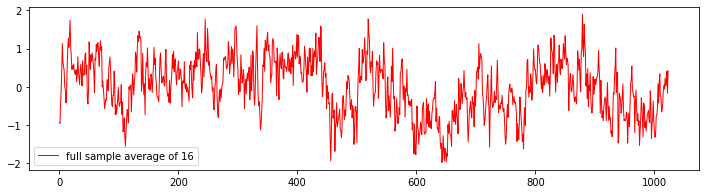

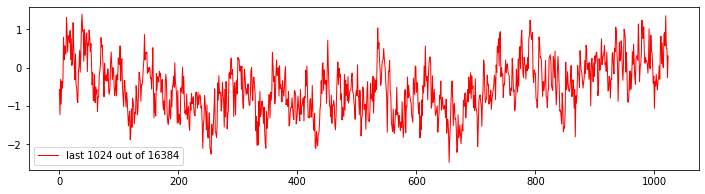

In [8]:
Ns = 12     # number of sources
tau0 = 2    # geometric sequence of tau's with ratio = tau0
N = 2**14   # sample size

Sk,Sv,Sp,Sc = TRIinit(Ns,tau0)    # initialize sources
X = np.empty(N,dtype=np.float32)  # use 32-bit floats to save on memory
GenTRI(X,Sk,Sv,Sp,Sc)             # generate sample
f1 = plt.figure(1) 
navg=N//1024
plt.plot(X.reshape((1024,navg)).mean(axis=1), color='red', linewidth=1, label='full sample average of %d'%navg)
plt.legend()
f1.set_size_inches(12,3)

f2 = plt.figure(2) 
plt.plot(X[-1024:], color='red', linewidth=1, label='last 1024 out of %d'%N)
plt.legend()
f2.set_size_inches(12,3)  

100 samples of size 65536 in 1.01 sec
sample avg 3.087e-03 var 0.6961


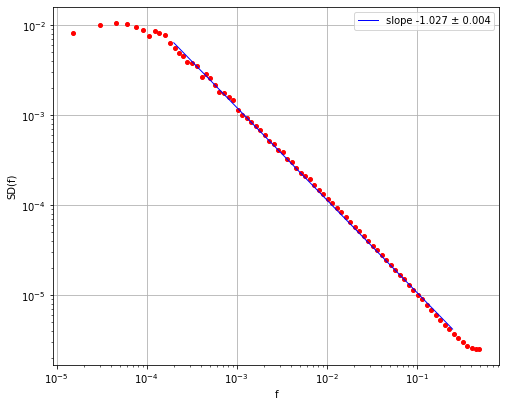

Text(0, 0.5, 'fxSD(f)')

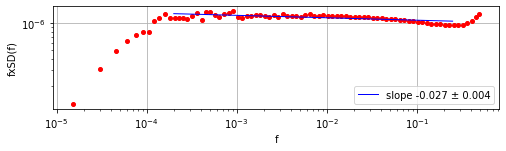

In [9]:
# Spectral Density
Ns = 12     # number of sources
tau0 = 2    # geometric sequence of tau's with ratio = tau0
N = 2**16   # sample size
Nrun = 100  # samples to average

Sk,Sv,Sp,Sc = TRIinit(Ns,tau0)      # initialize sources
X = np.empty(N,dtype=np.float32)    # use 32-bit floats to save on memory
nsd = N//2+2                        # spectral density size 
sd = np.zeros(nsd,dtype=np.float32) # space for spectral density 

t0 = time.perf_counter()            # starting time
for m in range(Nrun):
  GenTRI(X,Sk,Sv,Sp,Sc)             # generate sample
  addSD(X,sd)                       # add to spectral density, this destroys X
print("%d samples of size %d in %0.2f sec" % (Nrun,N,time.perf_counter()-t0))  
fa,sda,na,avg,var = loglogSD(sd,20)     # sd averaged to 20 points/decade
print("sample avg %0.3e var %0.4f" % (avg,var))
loglogPlot(fa,sda,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.show()
loglogPlot(fa,sda*fa,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.gca().set_ylabel('fxSD(f)')

### modified SQU sources
Allow non integer periods, randomized time at each period, and source strength parameter to alter the spectral density about $1/f$.

**`SQMinit()`** initializes the parameters for the array of sources while **`GenSQM(X)`** generates in-place samples in array **`X`**.

The following uses **`random()-0.5`** for uniformly distributed random values from -0.5 to 0.5. This could be replaced by **`standard_normal()`** for a normal/Gaussian distribution.

In [10]:
from numpy.random import random as RanVal
# from numpy.random import standard_normal as RanVal  # uncomment for Gaussian and remove '-0.5'
from numpy.random import random as rand  # uniform distribution [0,1)

def SQMinit(Ns,tau0,alpha=0.0,taumin=1):
  "return the Sv and Sk numpy arrays for Ns sources with period tau0 and initial source sum Ssum"
  tau2 = 0.5*tau0                        # avg decrement is 0.5
  Sv = np.empty(Ns,dtype=np.float64)     # source random values
  Sk = tau2*np.ones(Ns,dtype=np.float64) # source indices, 0 forces update
  Sp = tau2*np.ones(Ns,dtype=np.float64) # source periods relative to previous
  Sn = np.zeros(Ns,dtype=np.int64)       # count of source changes 
  Sp[0] = 0.5*taumin
  Ssum = 0.0
  Sa = np.ones(Ns,dtype=np.float64)      # source amplitude multiplier
  for k in range(Ns):                    # initialize sources
    Sv[k] = rand()-0.5                   # initial random value
    Ssum += Sv[k]                        # accumulate initial source sum
    Sa[k] = tau0**(k*alpha)              # source strengths
  return Ssum,Sk,Sp,Sn,Sv,Sa      

@numba.jit(nopython=True)        # pre compile for faster execution
def GenSQM(X,Ssum,Sk,Sp,Sn,Sv,Sa):
  "fill np array X with samples derived from Ssum,Sk,Sv,Sa SQM sources, random decrements"
  for i in range(X.size):
    for k in range(Sk.size):     # check sources for possible updates
      Sk[k] -= rand()            # random decrement count avg = 0.5
      if Sk[k]>0: break          # no change for this or higher k
      Ssum -= Sv[k]              # remove previous value from Ssum
      Sv[k] = Sa[k]*(RanVal()-0.5) # new uniform random value avg=0 scaled by Sa[k]
      Sk[k] += Sp[k]             # reset period, preserve remainder
      Ssum += Sv[k]              # replace with new value
      Sn[k] += 1                 # count changes
    X[i] = Ssum                  # save value  
  return Ssum                    # return Ssum for continuity

### Generate, plot and measure spectral density of SQM samples

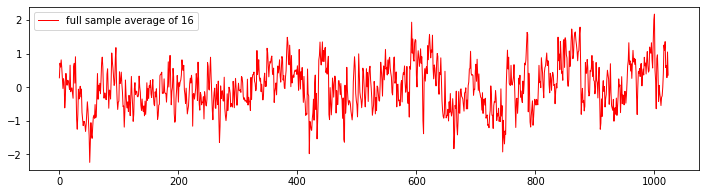

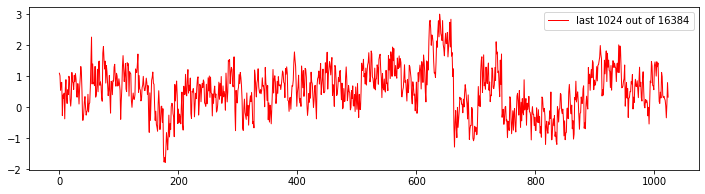

In [11]:
Ns = 8        # number of sources
tau0 = 7**0.5 # geometric sequence of tau's with ratio = sqrt(7)
N = 2**14     # sample size

Ssum,Sk,Sp,Sn,Sv,Sa = SQMinit(Ns,tau0)    # initialize sources
X = np.empty(N,dtype=np.float32)    # use 32-bit floats to save on memory
Ssum = GenSQM(X,Ssum,Sk,Sp,Sn,Sv,Sa) # generate sample
f1 = plt.figure(1) 
navg=N//1024
plt.plot(X.reshape((1024,navg)).mean(axis=1), color='red', linewidth=1, label='full sample average of %d'%navg)
plt.legend()
f1.set_size_inches(12,3)

f2 = plt.figure(2) 
plt.plot(X[-1024:], color='red', linewidth=1, label='last 1024 out of %d'%N)
plt.legend()
f2.set_size_inches(12,3)  

100 samples of size 65536 in 0.55 sec
sample avg -1.266e-03 var 0.2527
100 samples of size 65536 in 0.59 sec
sample avg -1.156e-02 var 4.1321


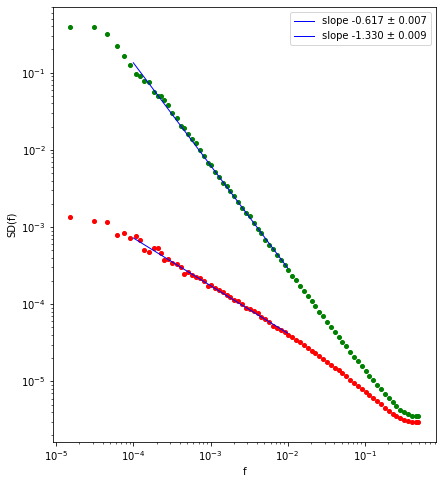

In [12]:
# Spectral Density
Ns = 10       # number of sources
tau0 = 7**0.5 # geometric sequence of tau's with ratio = sqrt(7)
N = 2**16     # sample size
Nrun = 100    # samples to average

X = np.empty(N,dtype=np.float32)    # use 32-bit floats to save on memory
nsd = N//2+2                        # spectral density size 
sd = np.zeros(nsd,dtype=np.float32) # space for spectral density 

alpha = -0.2
Ssum,Sk,Sp,Sn,Sv,Sa = SQMinit(Ns,tau0,alpha)    # initialize sources
t0 = time.perf_counter()               # starting time
for m in range(Nrun):
  Ssum = GenSQM(X,Ssum,Sk,Sp,Sn,Sv,Sa) # generate sample
  addSD(X,sd)                          # add to spectral density, this destroys X
print("%d samples of size %d in %0.2f sec" % (Nrun,N,time.perf_counter()-t0))  
fa,sda,na,avg,var = loglogSD(sd,20)    # sd averaged to 20 points/decade
print("sample avg %0.3e var %0.4f" % (avg,var))
loglogPlot(fa,sda,1e-4,1e-2,"'ro',markersize=4","'b-',linewidth=1")

alpha = 0.2
Ssum,Sk,Sp,Sn,Sv,Sa = SQMinit(Ns,tau0,alpha)    # initialize sources
t0 = time.perf_counter()               # starting time
for m in range(Nrun):
  Ssum = GenSQM(X,Ssum,Sk,Sp,Sn,Sv,Sa) # generate sample
  addSD(X,sd)                          # add to spectral density, this destroys X
print("%d samples of size %d in %0.2f sec" % (Nrun,N,time.perf_counter()-t0))  
fa,sda,na,avg,var = loglogSD(sd,20)    # sd averaged to 20 points/decade
print("sample avg %0.3e var %0.4f" % (avg,var))
loglogPlot(fa,sda,1e-4,1e-2,"'go',markersize=4","'b-',linewidth=1")


### Equalizing computational costs for **SQU** sources with $\tau_0=2$.

The **SQU** and **SQM** algorithms presented above have a widely varying
computational cost/step. For $\tau_0=2$ every other step only requires a single source update, every 2nd updates 2 sources, every 4th 3, and every $2^k$ step updates $k$ sources. If the source update is base on a change in the binary representation of the integer step counter, then a source is updated only if the corresponding binary digit is changed from the previous step. However, the average number of source updates/step is slightly less than 2.

After the **Fractals** article was submitted for publication the author was made aware of other work in the DSP community.
A variation of the [Binary Reflected Gray Code](https://en.wikipedia.org/wiki/Gray_code) was discussed in an [online DSP forum](https://www.firstpr.com.au/dsp/pink-noise/#Voss-McCartney) in 1999 that evens out the computation to 2 updates at each step. 
The count of the number of trailing zeros in the binary representation of the
integer step count determines which of the higher index sources is updated at each step.
A Python implementation is shown in the cells below.

Although the computation cost/step is nearly constant, the spectral density shows the same **lacunarity** as the **SQU** implementation above and the efficient coding for $\tau_0=2$ is not easily extended to other values.

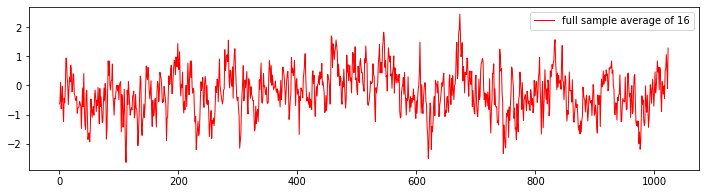

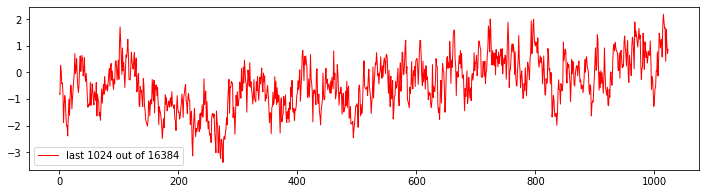

In [15]:
# test Reflected Binary Gray Code to equalize updates/step.
from numpy.random import random as RanVal
# from numpy.random import standard_normal as RanVal  # uncomment for Gaussian and remove '-0.5'

def SQZinit(Ns):
  "return the Sv numpy array for Ns sources with period 2 and initial Source sum Ssum"
  Sv = np.empty(Ns-1,dtype=np.float64)   # source random values
  Ssum = 0.0
  Scnt = 0
  for k in range(Ns-1):   # initialize sources
    Sv[k] = RanVal()-0.5 # initial random value
    Ssum += Sv[k]        # accumulate initial source sum 
  return Ssum,Scnt,Sv      

@numba.jit(nopython=True)  # pre compiles for faster execution
def GenSQZ(X,Ssum,Scnt,Sv):
  "fill np array X with SQU samples derived from Ssum,Sk,Sv SQU sources"
  for i in range(X.size):
    Scnt += 1              # next count
    # the following convoluted numpy code calculates the number of trailing zeros
    # in Scnt which gives the single higher tau source to update on each iteration
    k = int(np.ceil(np.log2((Scnt&-Scnt)+1)))
    if k<Sv.size:
      Ssum -= Sv[k]        # remove previous value from Ssum
      Sv[k] = RanVal()-0.5 # new random value 
      Ssum += Sv[k]        # replace with new value
    X[i] = Ssum + RanVal()-0.5   # save value with new period 1 component
  return Ssum,Scnt         # return Ssum,count for continuity  

#                                  generate and plot a sample
Ns = 12     # number of sources
N = 2**14   # sample size

Ssum,Scnt,Sv = SQZinit(Ns)        # initialize sources
X = np.empty(N,dtype=np.float32)  # use 32-bit floats to save on memory
GenSQZ(X,Ssum,Scnt,Sv)            # generate sample
f1 = plt.figure(1) 
navg=N//1024
plt.plot(X.reshape((1024,navg)).mean(axis=1), color='red', linewidth=1, label='full sample average of %d'%navg)
plt.legend()
f1.set_size_inches(12,3)

f2 = plt.figure(2) 
plt.plot(X[-1024:], color='red', linewidth=1, label='last 1024 out of %d'%N)
plt.legend()
f2.set_size_inches(12,3)  

100 samples of size 65536 in 0.45 sec
avg 8.263e-02 var 9.123e-01


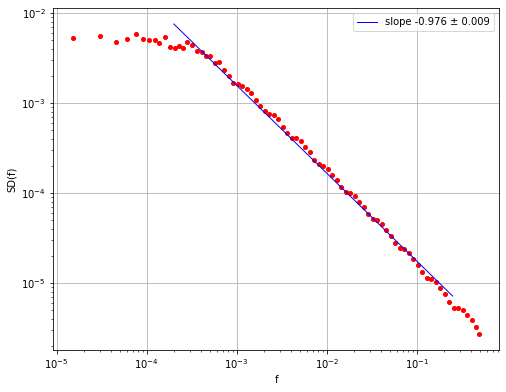

Text(0, 0.5, 'fxSD(f)')

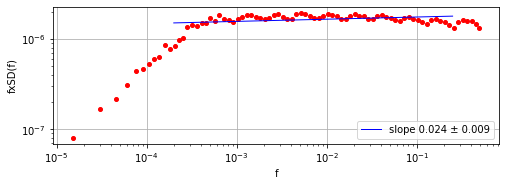

In [16]:
# now for the spectral density
Ns = 12     # number of sources
tau0 = 2    # geometric sequence of tau's with ratio = tau0
N = 2**16   # sample size
Nrun = 100  # samples to average

Ssum,Scnt,Sv = SQZinit(Ns)        # initialize sources
X = np.empty(N,dtype=np.float32)    # use 32-bit floats to save on memory
nsd = N//2+2                        # spectral density size 
sd = np.zeros(nsd,dtype=np.float32) # space for spectral density 

t0 = time.perf_counter()            # starting time
for m in range(Nrun):
  Ssum,Scnt = GenSQZ(X,Ssum,Scnt,Sv)            # generate sample
  addSD(X,sd)                       # add to spectral density, this destroys X
print("%d samples of size %d in %0.2f sec" % (Nrun,N,time.perf_counter()-t0))  
fa,sda,na,avg,var = loglogSD(sd,20)     # sd averaged to 20 points/decade
print("avg %0.3e var %0.3e" % (avg,var))
loglogPlot(fa,sda,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.show()
loglogPlot(fa,sda*fa,2e-4,0.25,"'ro',markersize=4","'b-',linewidth=1")
plt.gca().set_ylabel('fxSD(f)')

#### The use of randomized updates was suggested in the DSP community referenced above to reduce the spectral "ripple".

A numpy version appeared in 2015 as a [.ipyny notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb). The algorithm appears to work wih a global random selection of updates for each source rather than the incremental approach presented here.